In [172]:
import re
from nltk.corpus import words
import io
import glob
import nltk
import string
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import math
from fa2 import ForceAtlas2
from collections import Counter
from community import community_louvain
from wordcloud import WordCloud
import statistics

%matplotlib inline

# Part 1: Twitter Network Analysis

## Exercise 1: Build the network of retweets
We will now build a network that has as nodes the Twitter handles of the members of the house, and direct edges between nodes A and B if A has retweeted content posted by B. We will build a weighted network, where the weight of an edge is equal to the number of retweets. You can build the network following the steps below (and you should be able to reuse many of the functions you have written as part of the exercises during the previous weeks):

* **Consider the 200 most recent tweets written by each member of the house (use the files [here](https://github.com/suneman/socialgraphs2019/tree/master/files/data_twitter/tweets_2019.zip/). For each file, use a regular expression to find retweets and to extract the Twitter handle of the user whose content was retweeted. All retweets begin with "*RT @originalAuthor:*", where "*originalAuthor*" is the handle of the user whose content was retweeted (and the part of the text you want to extract).**

*According to Twitter offical page (https://help.twitter.com/en/managing-your-account/twitter-username-rules), Twitter handles can only contain letters, digits and underscores. This explains the regular expression pattern we choose to use below.*

In [2]:
# define a function to find the original author and the content of ONE member's retweets 

def find_retweets(path):
    
    # first, read the tweets of a particular member
    # io module is chosen for its encoding parameter as utf-8 encoding is needed
    f = io.open(path, mode="r", encoding="utf-8").read()
    
    # then, use regex to find all retweets of this member
    # result is stored in a tuple of tuples of the following format: 
    # ((originalAuthor1, content1),(originalAuthor2, content2),...)
    tup = re.findall(r"RT @([a-zA-Z0-9_]+): (.*)", f) # letter, digit and underscore

    return tup

* For each retweet, check if the handle retweeted is indeed the handle of a member of the house. If yes, keep it. If no, discard it.

In [3]:
# load Twitter handles of the members of the house
members_df = pd.read_csv("H115_tw_2019.csv")
members_df.head()

WikiPageName       Party       State  \
0                            Don_Young  Republican      Alaska   
1                    Jim_Sensenbrenner  Republican   Wisconsin   
2                           Hal_Rogers  Republican    Kentucky   
3  Chris_Smith_(New_Jersey_politician)  Republican  New Jersey   
4                          Steny_Hoyer  Democratic    Maryland   

                Name         tw_id         tw_name  
0          Don Young  3.700727e+07     repdonyoung  
1  Jim Sensenbrenner  8.516214e+08  JimPressOffice  
2         Hal Rogers  5.504018e+08    RepHalRogers  
3        Chris Smith  1.289319e+09   RepChrisSmith  
4        Steny Hoyer  2.201209e+07     LeaderHoyer

We will do some cleaning because not every members' tweets are available.

For those whose tweets are not available, as mentioned by TA, we will delete them from the memebrs_df data frame.

In [25]:
# get all the Wiki names from the tweets files
file_wiki=[]
for file in glob.glob("tweets_2019_full/*"):
    name=file[17:]
    file_tw.append(name)
len(file_wiki)    

334

In [26]:
# get all the Wiki names from the dataset
df_wiki=members_df.WikiPageName.tolist()
len(df_wiki)

336

In [28]:
# whose tweets data are missing
set(df_wiki)-set(df_wiki)

{'Rob_Bishop', 'Roger_Marshall_(politician)'}

In [30]:
# delete them from data set
members_df=members_df[members_df['WikiPageName'] != 'Rob_Bishop']
members_df=members_df[members_df['WikiPageName'] != 'Roger_Marshall_(politician)']
len(members_df)

334

*Create three dictionaries for convertering between various member information:*

In [41]:
# some data extraction to build dictionary
tw_name = members_df.tw_name.tolist()
party=members_df.Party.tolist()
wiki_name=members_df.WikiPageName.tolist()

In [32]:
# dictionary that maps wikiname to party
wikiName_party_dic={}

for i in range(len(wiki_name)):
    wikiName_party_dic[wiki_name[i]] = party[i]

wikiName_party_dic

{'Don_Young': 'Republican',
 'Jim_Sensenbrenner': 'Republican',
 'Hal_Rogers': 'Republican',
 'Chris_Smith_(New_Jersey_politician)': 'Republican',
 'Steny_Hoyer': 'Democratic',
 'Marcy_Kaptur': 'Democratic',
 'Pete_Visclosky': 'Democratic',
 'Peter_DeFazio': 'Democratic',
 'John_Lewis_(civil_rights_leader)': 'Democratic',
 'Fred_Upton': 'Republican',
 'Nancy_Pelosi': 'Democratic',
 'Frank_Pallone': 'Democratic',
 'Eliot_Engel': 'Democratic',
 'Nita_Lowey': 'Democratic',
 'Richard_Neal': 'Democratic',
 'José_E._Serrano': 'Democratic',
 'David_Price_(American_politician)': 'Democratic',
 'Rosa_DeLauro': 'Democratic',
 'Maxine_Waters': 'Democratic',
 'Jerrold_Nadler': 'Democratic',
 'Jim_Cooper': 'Democratic',
 'Ken_Calvert': 'Republican',
 'Jim_Clyburn': 'Democratic',
 'Anna_Eshoo': 'Democratic',
 'Gene_Green': 'Democratic',
 'Alcee_Hastings': 'Democratic',
 'Peter_T._King': 'Republican',
 'Carolyn_Maloney': 'Democratic',
 'Lucille_Roybal-Allard': 'Democratic',
 'Bobby_Rush': 'Democratic

In [33]:
# dictionary that maps tw_name to party
twName_party_dic={}

for i in range(len(tw_name)):
    twName_party_dic[tw_name[i]] = party[i]

twName_party_dic

{'repdonyoung': 'Republican',
 'JimPressOffice': 'Republican',
 'RepHalRogers': 'Republican',
 'RepChrisSmith': 'Republican',
 'LeaderHoyer': 'Democratic',
 'RepMarcyKaptur': 'Democratic',
 'RepVisclosky': 'Democratic',
 'RepPeterDeFazio': 'Democratic',
 'repjohnlewis': 'Democratic',
 'RepFredUpton': 'Republican',
 'SpeakerPelosi': 'Democratic',
 'FrankPallone': 'Democratic',
 'RepEliotEngel': 'Democratic',
 'NitaLowey': 'Democratic',
 'RepRichardNeal': 'Democratic',
 'RepJoseSerrano': 'Democratic',
 'RepDavidEPrice': 'Democratic',
 'rosadelauro': 'Democratic',
 'RepMaxineWaters': 'Democratic',
 'RepJerryNadler': 'Democratic',
 'repjimcooper': 'Democratic',
 'KenCalvert': 'Republican',
 'WhipClyburn': 'Democratic',
 'RepAnnaEshoo': 'Democratic',
 'RepMarkGreen': 'Democratic',
 'RepHastingsFL': 'Democratic',
 'RepPeteKing': 'Republican',
 'RepMaloney': 'Democratic',
 'RepRoybalAllard': 'Democratic',
 'RepBobbyRush': 'Democratic',
 'BobbyScott': 'Democratic',
 'BennieGThompson': 'Democra

In [34]:
# dictionary that maps wikiname to tw_name
wikiname_twName_dic={}

for i in range(len(tw_name)):
    wikiname_twName_dic[wiki_name[i]] = tw_name[i]

wikiname_twName_dic

{'Don_Young': 'repdonyoung',
 'Jim_Sensenbrenner': 'JimPressOffice',
 'Hal_Rogers': 'RepHalRogers',
 'Chris_Smith_(New_Jersey_politician)': 'RepChrisSmith',
 'Steny_Hoyer': 'LeaderHoyer',
 'Marcy_Kaptur': 'RepMarcyKaptur',
 'Pete_Visclosky': 'RepVisclosky',
 'Peter_DeFazio': 'RepPeterDeFazio',
 'John_Lewis_(civil_rights_leader)': 'repjohnlewis',
 'Fred_Upton': 'RepFredUpton',
 'Nancy_Pelosi': 'SpeakerPelosi',
 'Frank_Pallone': 'FrankPallone',
 'Eliot_Engel': 'RepEliotEngel',
 'Nita_Lowey': 'NitaLowey',
 'Richard_Neal': 'RepRichardNeal',
 'José_E._Serrano': 'RepJoseSerrano',
 'David_Price_(American_politician)': 'RepDavidEPrice',
 'Rosa_DeLauro': 'rosadelauro',
 'Maxine_Waters': 'RepMaxineWaters',
 'Jerrold_Nadler': 'RepJerryNadler',
 'Jim_Cooper': 'repjimcooper',
 'Ken_Calvert': 'KenCalvert',
 'Jim_Clyburn': 'WhipClyburn',
 'Anna_Eshoo': 'RepAnnaEshoo',
 'Gene_Green': 'RepMarkGreen',
 'Alcee_Hastings': 'RepHastingsFL',
 'Peter_T._King': 'RepPeteKing',
 'Carolyn_Maloney': 'RepMaloney',


*define a function to check if the original authors of a person's retweets are members of the house:*

In [35]:
def check_if_member(tup):
    
    # initialize a list that only stores retweets whose original author is a member of the house 
    retweets_list = []
    
    # iterate through the reweets tuple and examine the original author of each retweet
    for grp in tup:
        
        # add to the list if original author is a member
        if grp[0] in tw_name:
            retweets_list.append(grp)
            
    return retweets_list

*define a function to find and filter ALL members' retweets:*

In [36]:
def process_all():
    
    # initialize a dictionary that stores the Wikipedia name of the member, 
    # the author of his/her retweets (must be a house member too), and the content of these retweets.
    # format: {houseMember1 : [(originalAuthor1, content1),(...,...),...],  houseMember2 : [(...,...),(...,...),...],  ...}
    retweets_dict = {}
    
    # iterate through every file in the directory
    for file in glob.glob("tweets_2019_full/*"):
        
        # find the retweet list of each house member
        retweets_list = check_if_member(find_retweets(file))
        
        # extract the name of the house member
        tw_name = wikiname_twName_dic[file[17:]]
        
        # append the name and retweets info to the dictionary
        retweets_dict[tw_name] = retweets_list
    
    return retweets_dict

*finally, build the full dictionary*

In [37]:
retweets_full_dict = process_all()
retweets_full_dict

{'NormaJTorres': [('SpeakerPelosi',
   'I am deeply concerned that the White House has canceled an all-Member classified briefing on the dangerous situation the…RT @I am deeply concerned that the White House has canceled an all-Member classified briefing on the dangerous situation the President has caused in Syria, denying the Congress its right to be informed as it makes decisions about our national security.')],
 'RepJimCosta': [('RepThompson',
   'I joined 213 of my colleagues to demand McConnell immediately call the Senate back and pass #HR8 and #HR1112, two bipartis…RT @I joined 213 of my colleagues to demand McConnell immediately call the Senate back and pass #HR8 and #HR1112, two bipartisan bills to help prevent gun violence and save lives. The House passed these bills 160+ days ago and it’s long past time for the Senate to act. #DoSomething https://t.co/3pm8tBslPV')],
 'RepTomSuozzi': [('CongressmanRaja',
   'Please join us tomorrow for the launch of our new Caucus to End the Y

* **Use a NetworkX [`DiGraph`](https://networkx.github.io/documentation/development/reference/classes.digraph.html) to store the network. Use weighted edges to account for multiple retweets. Also store the party of each member as a node attribute (use the data in [this file](https://github.com/suneman/socialgraphs2019/blob/master/files/data_twitter/H115_tw_2019.csv). Remove self-loops (edges that connect a node with itself).**

*We want to find the number of re-tweets between two members:*

In [38]:
# build a dictionary with the following structure
# {(A, B) : n1, (A, C) : n2, (B, D) : n3 , ...}
# meaning that A retweets B for a total of n1 times

graph_dic={}

for k,v in retweets_full_dict.items(): # k is tw name, v is all the filtered tweets
    for pair in v:
        key = (k, pair[0]) # key for new dictionary (user, original user)
        if key in graph_dic:
            graph_dic[key] += 1
        else:
            graph_dic[key] = 1

In [39]:
graph_dic

{('NormaJTorres', 'SpeakerPelosi'): 1,
 ('RepJimCosta', 'RepThompson'): 1,
 ('RepTomSuozzi', 'CongressmanRaja'): 1,
 ('RepTomSuozzi', 'JeffFortenberry'): 1,
 ('RepTomSuozzi', 'RepBrianFitz'): 1,
 ('RepBeatty', 'RepRobinKelly'): 1,
 ('RepBeatty', 'RepRaulGrijalva'): 1,
 ('RepBeatty', 'RepKarenBass'): 1,
 ('RepBeatty', 'RepLBR'): 1,
 ('RepBeatty', 'RepMarciaFudge'): 1,
 ('RepBillJohnson', 'RepBillJohnson'): 1,
 ('RepBillJohnson', 'GOPLeader'): 1,
 ('RepBillJohnson', 'SteveScalise'): 1,
 ('RepMcGovern', 'RepRaulGrijalva'): 1,
 ('RepMcGovern', 'RepSwalwell'): 1,
 ('RepMcGovern', 'SpeakerPelosi'): 3,
 ('RepMcGovern', 'RepMarciaFudge'): 1,
 ('RepMcGovern', 'RepLBR'): 1,
 ('RepMcGovern', 'RepValDemings'): 1,
 ('RepMcGovern', 'RepRaskin'): 1,
 ('RepMcGovern', 'RepDianaDeGette'): 1,
 ('RepMcGovern', 'RepKClark'): 1,
 ('RepClayHiggins', 'RepMarkMeadows'): 1,
 ('RepClayHiggins', 'SteveScalise'): 3,
 ('RepClayHiggins', 'GOPLeader'): 3,
 ('RepClayHiggins', 'RepGarretGraves'): 1,
 ('RepAnnaEshoo', '

*Build a directed graph:*

In [44]:
def build_Graph():

    # initialize a directed graph
    G=nx.DiGraph()
    
    # add nodes as tw_name and party for each member as node attribute
    for username in tw_name:
        G.add_node(username, party = twName_party_dic[username])
    
    # add edges between members and weight stands for the number of retweets
    for k,v in graph_dic.items():
        G.add_edge(k[0], k[1], weight = v)
    
    # remove self-loop as required
    for node in list(G.nodes):
        try:
            G.remove_edge(node,node)
            print("removing self-loop for {}".format(node))
        except:
            pass
    return G

In [45]:
G = build_Graph()

removing self-loop for RepFredUpton
removing self-loop for RepEliotEngel
removing self-loop for RepDavidEPrice
removing self-loop for RepJerryNadler
removing self-loop for RepMarkGreen
removing self-loop for RepRoybalAllard
removing self-loop for BobbyScott
removing self-loop for RepLloydDoggett
removing self-loop for BillPascrell
removing self-loop for RepSteveChabot
removing self-loop for LacyClayMO1
removing self-loop for RepAdamSchiff
removing self-loop for SteveKingIA
removing self-loop for repcleaver
removing self-loop for virginiafoxx
removing self-loop for RepAlGreen
removing self-loop for RepYvetteClarke
removing self-loop for RepCohen
removing self-loop for RepJoeCourtney
removing self-loop for congbillposey
removing self-loop for RepPaulTonko
removing self-loop for RepTedDeutch
removing self-loop for justinamash
removing self-loop for RepKarenBass
removing self-loop for davidcicilline
removing self-loop for RepJeffDuncan
removing self-loop for RepHartzler
removing self-loop 

## Exercise 2: Visualize the network of retweets and investigate differences between the parties

* **Visualize the network using the [Networkx draw function](https://networkx.github.io/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw.html#networkx.drawing.nx_pylab.draw), and nodes coordinates from the force atlas algorithm. *Hint: use an undirected version of the graph to find the nodes positions for better results, but stick to the directed version for all measurements.* Plot nodes in colors according to their party (e.g. 'red' for republicans and 'blue' for democrats) and set the node-size to be proportional to total degree.**

*Map party to color and store in node_color list, according to the sequence in node list.*

In [46]:
# node color list
node_color=list(nx.get_node_attributes(G,'party').values())
node_color=list(map(lambda x : x.replace("Republican", "red"),node_color))
node_color=list(map(lambda x : x.replace("Democratic", "blue"),node_color))

*Find node degree and store in degree_list list, according to the sequence in node list.*

In [47]:
degree_list=list(map(lambda x : x[1], list(G.degree)))

*Set node size to be proportional to the degree and store this information in the `node_size` list*

In [48]:
node_size=list(map(lambda x : x/sum(degree_list), degree_list))

*Use Force Atlas algorithm to find the position of undirected version of graph G.*

In [49]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=0,

                        # Performance
                        jitterTolerance=0.0001,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=0.08,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=0.001,
                        strongGravityMode=False,
                        gravity=0,

                        # Log
                        verbose=False)

In [50]:
positions = forceatlas2.forceatlas2_networkx_layout(G.to_undirected(), 
                                                    pos=None,iterations=10000)

Visualize the graph.

//anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


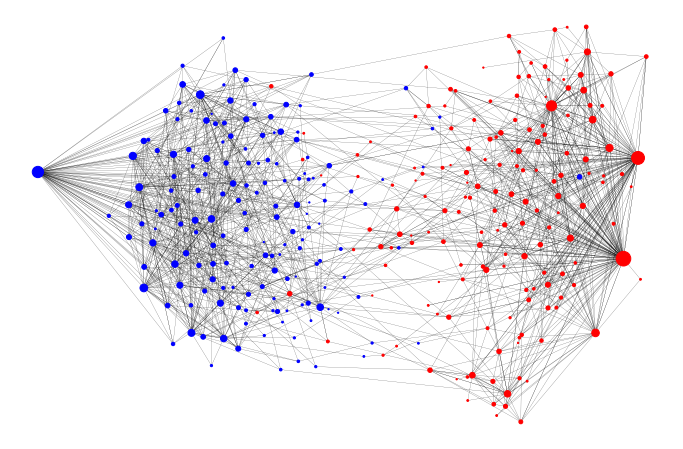

In [51]:
plt.figure(figsize=(12,8))
plt.axis("off")
nx.draw_networkx(G, positions, 
        node_size=[x*5000 for x in node_size], node_color=node_color,
        node_shape='o',
        width=0.15,
        arrows=False,
        with_labels=False)

* **Compare the network of Retweets with the network of Wikipedia pages (generated during Week 5). Do you observe any differences? How do you explain them?**

*We will attach a network of Wikipedia pages generated during week 5.*

<div>
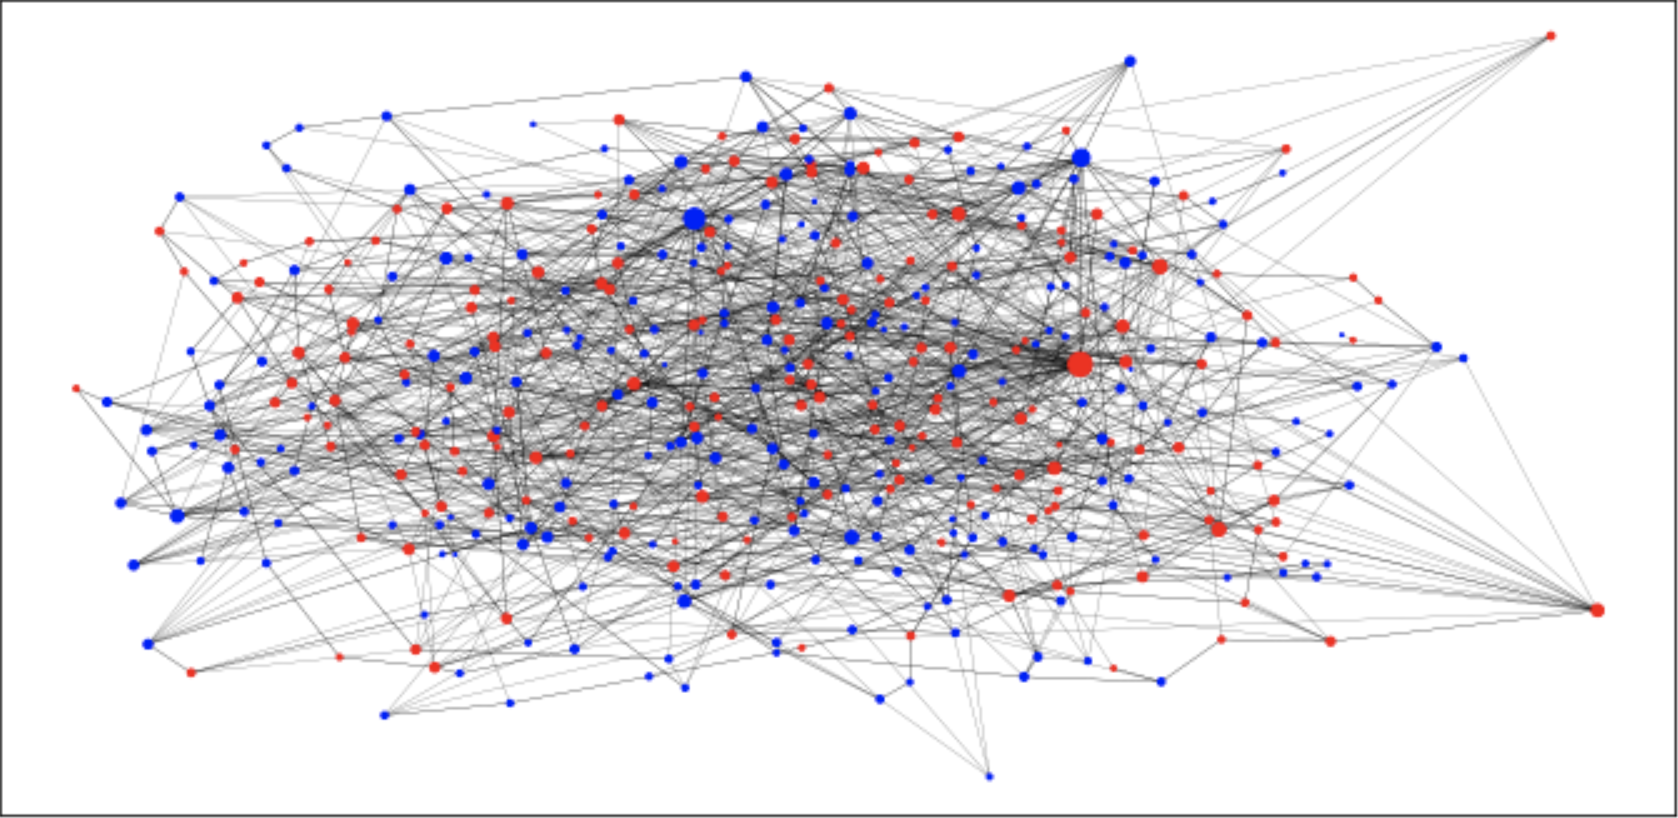
</div>

**In the network of Wikipedia pages:**
1. Members from both parties are very much interlinked.
2. There is no obvious clustering within the same party.
3. There is no drastic variation in the node sizes, meaning that the nodes have rather similar degrees.

**In the network of retweets:**
1. Members within the same party are interlinked. However, there are few edges connecting memebrs from different parties.
2. There are two obvious clusters, one for each party.
3. There is significant variations in the node sizes, indicating that the nodes have a wide range of degree distribution.

**Possible explanations include:**
1. Wikipedia pages are more objective in introducing each member, including their possible relationships/interactions with members from the opposing parties (e.g. disputes, open discussions). As a result, the Wikipedia network shows more connnecting edges between nodes from the different parties.
2. Members from the same party are more likely to follow/interact with those who are from the same party, and thus more active in retweeting each other's posts (e.g. to publicize campaigns). Therefore, there are two distinct clusters in retweet network.
3. Some members use twitter more frequently than others, so they have a larger node degree than the rest. This explains why nodes in retweet network show a wider range of degree distribution.

* **Now set the node-size tob proportional to betweenness centrality. Do you observe any changes?**

In graph theory, betweenness centrality is a measure of centrality in a graph based on shortest paths. For every pair of vertices in a connected graph, there exists at least one shortest path between the vertices such that either the number of edges that the path passes through (for unweighted graphs) or the sum of the weights of the edges (for weighted graphs) is minimized.

Source: https://en.wikipedia.org/wiki/Betweenness_centrality

In our weighted graph, the edge weight represents number of retweets. Based on the definition of betweenness centrality for weighted graph above, we are supposed to calculate the sum of the edge weights on the shortest path. However, we realize that there is no meaning if we add edge weights (total number of retweets), because we are trying to analyze the amount of influence a node has over the flow of information (edge weight here does not represent the difficulty level for passing information, rendering it meaningless). Therefore, we will treat the edges as having the same weight.

Hence, we set `weight=None` in the below cell.

*Set node size to be proportional to betweenness centrality and store this information in the `betweenness` list*

In [52]:
betweenness=list(nx.betweenness_centrality(G, weight=None).values())

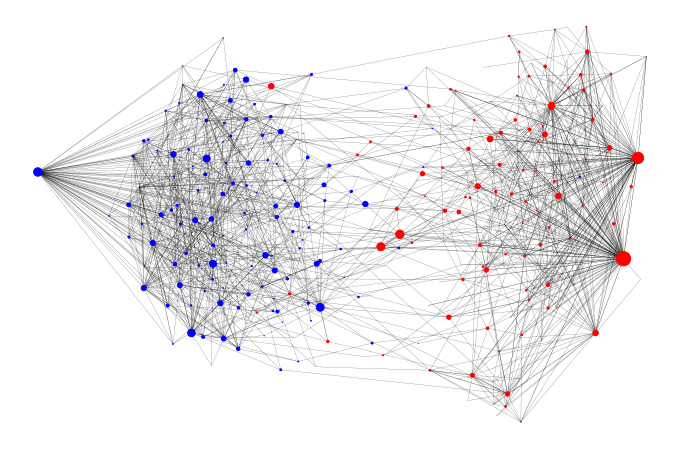

In [53]:
plt.figure(figsize=(12,8))
plt.axis("off")
nx.draw_networkx(G, positions, 
        node_size=[x*1000 for x in betweenness], node_color=node_color,
        node_shape='o',
        width=0.15,
        arrows=False,
        with_labels=False)

**We observe that:**
1. A few nodes positioned in between two clusters have grown in node size. This means they are important in connecting memebers between two parties. They serve as bridges in information flow.
2. Within each cluster, nodes with larger degree are in general bigger in the betweenness plot. This is because these nodes are more connected and thus appear more often in the shortest paths.

* **Repeat the point above using eigenvector centrality. Again, do you see a difference? Can you explain why based on what eigenvector centrality measures?**

Eigenvector centrality measures a node’s importance while giving consideration to the importance of its neighbors. If nodes with high degrees lead to the target node, the target node will have high eigenvector centrality.

*Set node size to be proportional to eigenvector centrality and store this information in the `eigenvector` list*

In [54]:
eigenvector=list(nx.eigenvector_centrality(G).values())

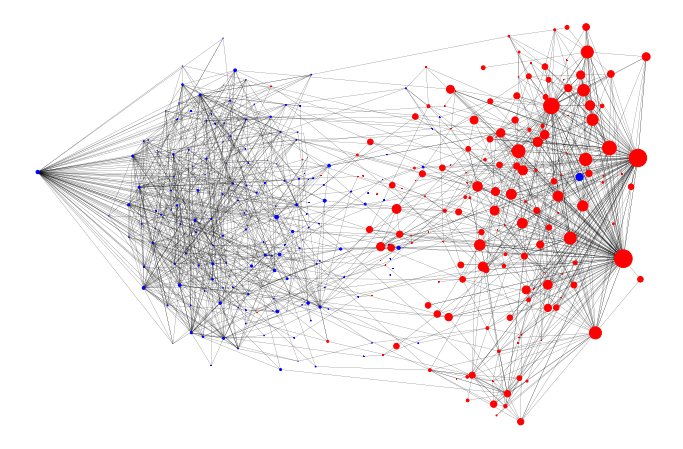

In [55]:
plt.figure(figsize=(12,8))
plt.axis("off")
nx.draw_networkx(G, positions, 
        node_size=[x*800 for x in eigenvector], node_color=node_color,
        node_shape='o',
        width=0.15,
        arrows=False,
        with_labels=False)

**We observe that:**
<br>
Republican nodes have higher eigenvector centrality than those belonging to Democrats. This might be because there are a few republicans whose degrees are so high they they are connected to almost every other republican nodes. On the other hand, democrats on average have a more equal degree distribution, leading to fewer high degree neighbors and thus lower eigenvector centrality. Additionally, republicans are more connected within their cluster. As a result, eigenvector centrality for republicans are high.

Interestingly, President Trump who uses twitter a looooooot is a Republican! 

* **Who are the three nodes with highest degree within each party? And what is their eigenvector centrality? And their betweenness centrality?**

define a function that prints the top `n` nodes in each party with the higihest degree

In [56]:
def get_Top_N(graph,n):
    
    # sort the graph nodes by their degrees
    sort_degree=sorted(list(G.degree),key=lambda x : x[1],reverse=True)
    
    # add party information into the sorted list
    sort_degree=[x + (twName_party_dic[x[0]],) for x in sort_degree]
    
    # filter republicans and democrats
    rep=[x for x in sort_degree if x[2] == 'Republican']
    demo=[x for x in sort_degree if x[2] == 'Democratic']
    
    print("Top {} nodes with highest degree in the Republican Party:".format(n))
    print(rep[:n])
    print("---------------------------------------------------------")
    print("Top {} nodes with highest degree in the Democratic Party:".format(n))
    print(demo[:n])
    return None

In [57]:
get_Top_N(G,3)

Top 3 nodes with highest degree in the Republican Party:
[('GOPLeader', 128, 'Republican'), ('SteveScalise', 99, 'Republican'), ('RepAndyBiggsAZ', 61, 'Republican')]
---------------------------------------------------------
Top 3 nodes with highest degree in the Democratic Party:
[('SpeakerPelosi', 76, 'Democratic'), ('RepRaulGrijalva', 35, 'Democratic'), ('RepLindaSanchez', 35, 'Democratic')]


Extract those 6 members' eigenvector centrality and betweenness centrality.

In [58]:
nodes_name=['GOPLeader','SteveScalise','RepAndyBiggsAZ',
            'SpeakerPelosi','RepRaulGrijalva','RepLindaSanchez']

In [59]:
print("Their eigenvector centrality are : ")
for item in [(name, nx.eigenvector_centrality(G)[name]) for name in nodes_name]:
    print(item)

Their eigenvector centrality are : 
('GOPLeader', 0.38962394342513085)
('SteveScalise', 0.379452390595441)
('RepAndyBiggsAZ', 0.3001000122248724)
('SpeakerPelosi', 0.013644437276218828)
('RepRaulGrijalva', 0.00979392878223808)
('RepLindaSanchez', 0.003819589267317919)


In [60]:
print("Their betweenness centrality are : ")
for item in [(name, nx.betweenness_centrality(G)[name]) for name in nodes_name]:
    print(item)

Their betweenness centrality are : 
('GOPLeader', 0.2025424895286802)
('SteveScalise', 0.1242754985872038)
('RepAndyBiggsAZ', 0.0444190057909117)
('SpeakerPelosi', 0.07069638120152029)
('RepRaulGrijalva', 0.02562377907526381)
('RepLindaSanchez', 0.03383469610651471)


* **Plot (on the same figure) the distribution of outgoing strength for the republican and democratic nodes repectively (i.e. the sum of the weight on outgoing links). Which party is more active in retweeting other members of the house?**

*Firstly, get the sum of the weights on outgoing links for all nodes.*

In [62]:
# get all out going weights for each node
out_weights=list(map(lambda x : (x[0], x[2]['weight']), list(G.edges.data())))

# store information into a dictionary where key is the tw name and value is the out weights
strength_dic={}
for tup in out_weights:
    if tup[0] in strength_dic:
        strength_dic[tup[0]] += tup[1]
    else:
        strength_dic[tup[0]] = tup[1]

*Secondly, filter republicans and democrats.*

In [63]:
rep_strength={}
demo_strength={}

for (k,v) in strength_dic.items():
    if twName_party_dic[k] == 'Republican':
        rep_strength[k] = v
    else:
        demo_strength[k] = v

*Thirdly, define bins to be used for both parties (since they have to be on the same plot)*

In [64]:
v=[5*i for i in range(0,25)]

Finally, make a plot!

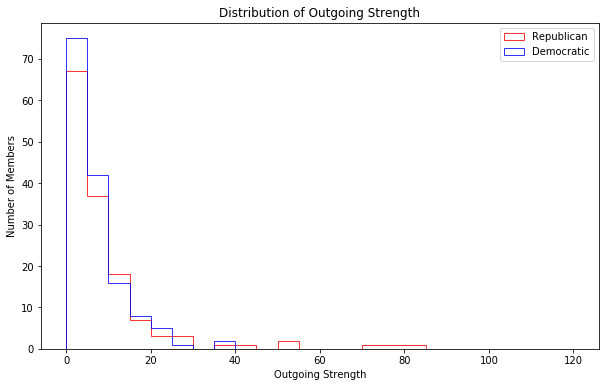

In [65]:
plt.figure(figsize=(10,6))
plt.hist(list(rep_strength.values()), histtype='step', 
         stacked=True, fill=False, bins=v, alpha = 0.8, color="red")

plt.hist(list(demo_strength.values()),histtype='step', 
         stacked=True, fill=False,bins=v,alpha = 0.8, color="blue")

plt.legend(('Republican','Democratic'))

plt.title("Distribution of Outgoing Strength")
plt.xlabel("Outgoing Strength")
plt.ylabel("Number of Members")
plt.show()

From the plot, the distribution in red (Republicans) is more right-skewed, meaning that they on average have more outgoing edges and thus are more active in retweeting other members of the house.

* **Find the 3 members of the republican party that have retweeted tweets from democratic members most often. Repeat the measure for the democratic members. Can you explain your results by looking at the Wikipedia pages of these members of the house?**

*Firstly, get the number of outgoing strength for all members.*

In [66]:
out_weights=list(map(lambda x : (x[0], x[1], x[2]['weight']), list(G.edges.data())))

In [35]:
out_weights

[('JimPressOffice', 'RepGrothman', 3),
 ('JimPressOffice', 'BobbyScott', 1),
 ('JimPressOffice', 'RepDougCollins', 3),
 ('JimPressOffice', 'RepScottPerry', 1),
 ('JimPressOffice', 'GOPLeader', 1),
 ('JimPressOffice', 'RepAnnieKuster', 1),
 ('JimPressOffice', 'RepBradWenstrup', 1),
 ('JimPressOffice', 'RepRonKind', 1),
 ('RepHalRogers', 'RepKClark', 2),
 ('RepHalRogers', 'SteveScalise', 1),
 ('RepHalRogers', 'RepRickAllen', 1),
 ('LeaderHoyer', 'RepAnthonyBrown', 1),
 ('LeaderHoyer', 'BobbyScott', 1),
 ('LeaderHoyer', 'RepLBR', 1),
 ('LeaderHoyer', 'RepDianaDeGette', 1),
 ('LeaderHoyer', 'JoaquinCastrotx', 1),
 ('RepMarcyKaptur', 'RepDianaDeGette', 1),
 ('RepMarcyKaptur', 'RepThompson', 1),
 ('RepMarcyKaptur', 'RepJerryNadler', 1),
 ('RepMarcyKaptur', 'RepLBR', 1),
 ('repjohnlewis', 'RepRichardNeal', 1),
 ('repjohnlewis', 'RepKClark', 1),
 ('repjohnlewis', 'RepJimmyGomez', 1),
 ('repjohnlewis', 'RepEspaillat', 1),
 ('repjohnlewis', 'RepJayapal', 1),
 ('RepFredUpton', 'SusanWBrooks', 1),

*Secondly, make sure that the retweets are between two members from different parties.*

In [67]:
def diff_party(lst):
    rep=[]
    demo=[]
    for tup in lst:
        if twName_party_dic[tup[0]] == 'Republican' and twName_party_dic[tup[1]] != 'Republican':
            rep.append(tup)
        elif twName_party_dic[tup[0]] != 'Republican' and twName_party_dic[tup[1]] == 'Republican':
            demo.append(tup)
    return (rep,demo)

In [68]:
# republicans retweeted democrats' tweets
rep=diff_party(out_weights)[0]

# democrats retweeted republicans' tweets
demo=diff_party(out_weights)[1]

*Thirdly, compute the number of retweets from opposite party for each member.*

In [69]:
def retweet_rank(lst):
    
    # initialise a new dictionary
    dic={}
    
    # tup is (person who retweeted, original author, number of times retweeted)
    for tup in lst:
        if tup[0] in dic:
            dic[tup[0]] += tup[2]
        else:
            dic[tup[0]] = tup[2]
            
    # return the sorted list in descending order
    return sorted(list(dic.items()), key=lambda x : x[1], reverse=True)

In [71]:
print("Top 3 Republicans who have retweeted tweets from Democrats the most:")
for x in retweet_rank(rep)[:3]:
    print(x)

Top 3 Republicans who have retweeted tweets from Democrats the most:
('RepBrianFitz', 10)
('RepRooney', 5)
('RepTomReed', 4)


In [74]:
print("Top 3 Democrats who have retweeted tweets from Republicans the most:")
for x in retweet_rank(demo)[:3]:
    print(x)

Top 3 Democrats who have retweeted tweets from Republicans the most:
('RepMarkGreen', 9)
('RepTedDeutch', 5)
('RepRichmond', 5)


* Brian Fitzpatrick (American politician) was ranked the third most bipartisan member of the House of Representatives by the Bipartisan Index. This means that he is heavily involved in cooperations between two parties. This could explain why he retweeted tweets from Democrats.

* Francis Rooney is strong advocate for global issues such as climate change, immigration and refugees and abortion. He might share the same opinions as some of the Democrats.

* Tom Reed (politician) initiated a House Rules change which intends to "lessen the sharp partisan divide in the House, in part by making it easier for rank-and-file members to bring their own bills onto the floor for a vote." He worked for cooperations between two parties and maybe it explains why he retweets a lot from Democrats.

* Mark E. Green has strong political positions in abortion, climate change, vaccines and creationism. These international topics are not restricted to a single party so he might retweet from Republicans.

* Ted Deutch was involved in gun policy and enviroment issues where he might retweet Republicans tweets to show disagreement or support.

* Cedric Richmond plays in the annual Congressional Baseball Game where he would make lots of interactions with other party memebers.

## Exercise 3: Community detection

* **Use your favorite method of community detection to find communities in the full house of representatives network. Report the value of modularity found by the algorithm. Is it higher or lower than what you found for the Wikipedia network (Week 7)? Comment on your result.**

In [101]:
# first compute the best partition
# best_partition only takes in non-directed graph. So we change the original graph to its undirected version.
non_directed=G.to_undirected()
partition = community_louvain.best_partition(non_directed, random_state = 11)

# Then, compute modularity
modurality=community_louvain.modularity(partition, non_directed, weight='weight')
modurality

0.48378452257517207

The modurality found for the Wikipedia network in week 7 is 0.4452285626989212, which is smaller than that of the network of retweets.

A higher modurality represents that the graph is better partitioned. This means the retweets network is more clearly partitioned than the Wikipedia network. However, the difference between these two are not very large, we can only reach a conclusion after observing some visualizations.

* **Visualize the network, using the Force Atlas algorithm. This time assign each node a different color based on their *community*. Describe the structure you observe.**

In [103]:
partition_values = list(partition.values())
partition_keys = list(partition.keys())
partition_items = list(partition.items())

In [93]:
# number of communities:
size = float(len(set(partition_values)))
size

18.0

In [271]:
colors=['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', 
        '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', 
        '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', 
        '#aaffc3', '#808000', '#ffd8b1']

//anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


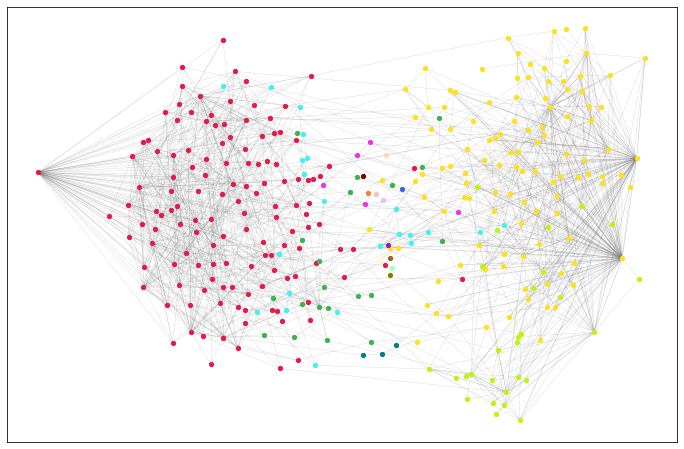

In [272]:
plt.figure(figsize=(12,8))
pos = positions # use Force Atlas positions

count = 0
for com in set(partition_values):
    list_nodes = [partition_keys[i] for i in range(len(partition_keys)) if partition_values[i] == com]
    nx.draw_networkx_nodes(G, pos, nodelist=list_nodes, node_size = 18, 
                           node_color = colors[count], node_shape='o')
    count = count + 1

nx.draw_networkx_edges(G,pos, list(G.edges), width=0.15, arrows=False, alpha=0.8, edge_color="gray")

plt.show()

There are in total 18 communities detected. Some communities have many nodes (e.g. red, yellow, light blue and light green communities). On the other hand, there are smaller communities such as pink, brown and maroon. The two largest communities, in our opinion, correspond to the two parties.

The partition of communities is not a very clear cut. However in general, nodes belonging to the same community are close to one another.

* **Compare the communities found by your algorithm with the parties by creating a matrix $\mathbf{D}$ with dimension $(B \times C$, where $B$ is the number of parties and $C$ is the number of communities. We set entry $D(i,j)$ to be the number of nodes that party $i$ has in common with community $j$. The matrix $\mathbf{D}$ is what we call a [confusion matrix]**(https://en.wikipedia.org/wiki/Confusion_matrix).

In [273]:
# we will use a helper dictionary
helper_dic={}

# init two keys in the helper dictionary. Helper dictionary only has two key-value pair
# {Republican : {},
#  Democratic : {}}
helper_dic["Republican"]={}
helper_dic["Democratic"]={}

# within each key value pair, the value is dictionary
# Republican : {
#  com1 : number1,
#  com2 : number2,
#  ...
#               }

for com in list(set(partition_values)):
    # for every new community label, init the count to be 0 in both parties
    helper_dic["Republican"][com]=0
    helper_dic["Democratic"][com]=0

# for each node in the graph
for (nodes,com) in partition_items:
    # get the party for that node
    party=G.node[nodes]['party']
    # update corresponding party community count
    helper_dic[party][com] += 1

rep=list(helper_dic['Republican'].values())
demo=list(helper_dic['Democratic'].values())
D=np.matrix([rep, demo])
print(D)

[[  5   5 106   1   0   0  13   3  28   1   2   0   0   1   1   0   0   0]
 [128  15   6   0   1   1   9   2   0   0   1   1   1   0   0   1   1   1]]


The first row represents Republican and the second row represents Democratic.

The first column is community 1, ... , the last column is community 21. 

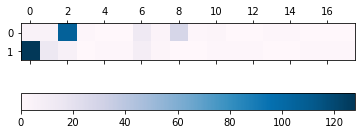

In [274]:
# visualize the matrix
fig, ax = plt.subplots()
cax = ax.matshow(D, cmap=plt.cm.PuBu)
fig.colorbar(cax, orientation = "horizontal")
plt.show()

* **Use the confusion matrix to explain how well the communities you've detected correspond to the parties. Consider the following questions**
  * Are there any republicans grouped with democrats (and vice versa)?
  * Does the community detection algorithm sub-divide the parties? Do you know anything about American politics that could explain such sub-divisions? Answer in your own words.

*Anser to Q1:* Yes. Whenever there are two non-zero values in a column, there is a mix of members from two parties. For example, community 1,2,3,7,8,11.

*Answer to Q2:* Yes. There are signs of sub-division. It is more obvious in Republican party in which the majority are in community 3, but a significant number of members are in community 7 or 9. Sub-division allows the algorithm to achieve a higher modurality.

This may be because that in each party, there are factions or wings. (https://en.wikipedia.org/wiki/Factions_in_the_Republican_Party_(United_States) and https://en.wikipedia.org/wiki/Factions_in_the_Democratic_Party_(United_States)) Even members in the same party may hold different opinions or ideologies.

# Part 2: What do republican and democratic members tweet about?

## Exercise 4: TF-IDF of the republican and democratic tweets
We will create two documents, one containing the words extracted from tweets of republican members, and the other for Democratic members. We will then use TF-IDF to compare the content of these two documents and create a word-cloud. The procedure you should use is exactly the same you used in exercise 2 of week 7. The main steps are summarized below:

* **Create two large documents, one for the democratic and one for the republican party. Tokenize the pages, and combine the tokens into one long list including all the pages of the members of the same party.**

*define a function to parse the tweets of ONE member of the house*

In [112]:
def find_preprocess_tweets(path):
        
    # first, read the tweets of a particular member
    # io module is chosen for its encoding parameter as utf-8 encoding is needed
    text = io.open(path, mode="r", encoding="utf-8").read()
    
    # replace newline character symbols in the text with a space
    text = re.sub(r'\n', ' ', text)
    
    # remove urls in the text
    # urls have little use in gathering insight into house members' tweet patterns
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    
    # replace word character symbols in the text with a space
    text = re.sub(r'/w', ' ', text)
        
    return text

*define a funciton to tokenize text*

In [113]:
def tokenize(text):
    word_tokens = nltk.tokenize.word_tokenize(text) # tokenize text
    return word_tokens

**1. Exclude the twitter handles of other members.**

*We are not quite sure of what this subtask is trying to achieve. If we do as what the task askes for, i.e. remove twitter handles of members of the opposing party, then what are left are:*
1. *handles of members of the same party*, 
2. *handles of users not belonging to any of the parties, and* 
3. *tweet content* 

*Point 1. and 2. are unlikely to give us insight into what the person tweets about, as they are just handles (usernames) which are not part of the tweets.*
<br>
<br>
*Therefore, our group has decided to remove all handles, i.e. `@username` from the text, and focus only on the tweet content itself*
<br>
<br>
*Please let us know if you interpret this subtask in a different way. We'd love to hear your thoughts on this!*

In [114]:
def exclude_twitter_handles(text):
    
    # remove retweet handles (RT @originalAuthor: )
    text = re.sub('RT @[a-zA-Z0-9_]+: ', '', text)
    
    # remove general 'at's (@username)
    text = re.sub('@[a-zA-Z0-9_]+', '', text)
    
    return text

**2. Exclude punctuation.**

In [115]:
# obtain a list of punctuations for later use
punctuations = [i for i in string.punctuation]

In [116]:
# extend the list of punctuations
punctuations += ['“','”','‘','’',"'s",'...','…','``',"''",'//','–']

In [117]:
punctuations

['!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~',
 '“',
 '”',
 '‘',
 '’',
 "'s",
 '...',
 '…',
 '``',
 "''",
 '//',
 '–']

**3. Exclude stop words (if you don't know what stop words are, go back and read NLPP1e again).**

In [118]:
# obtain a list of stop words for later use
stop_words = list(nltk.corpus.stopwords.words('english'))
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

**4. Exclude numbers (since they're difficult to interpret in the word cloud).**

In [119]:
# function to check if a string contains numbers
def exclude_numbers(text):
    return re.sub(r'\d', '', text)

**5. Set everything to lower case.**

In [120]:
def set_to_lower_case(text):
    return text.lower()

*putting everything together:*

In [121]:
# define a function to process tweets of ONE member

def process_one_member(path):
    
    # parse and process the text
    text = find_preprocess_tweets(path) # parse the tweets of ONE member of the house
    text = exclude_twitter_handles(text) # exclude twitter handles
    text = exclude_numbers(text) # exclude numbers
    text = set_to_lower_case(text) # set to lowercase
       
    # add punctuations and stop words to one list
    to_be_removed = punctuations + stop_words
    
    # tokenize the text
    word_tokens = tokenize(text)
        
    # remove punctuations and stop words
    word_tokens = [w for w in word_tokens if not w in to_be_removed]
    
    return word_tokens

In [122]:
# initialise two empty tokens
democratic_tokens = []
republican_tokens = []

In [125]:
# define a function to process tweets of ALL members, based on their parties

def process_all_members():
       
    # iterate through all files in the folder
    for file in glob.glob("tweets_2019_full/*"):
        
        # extract the wikiname of the house member
        name = file[17:]
        
        # obtain the path of each file
        path = "tweets_2019_full/" + name
        
        # tokenize the tweets of each house member
        word_tokens = process_one_member(path)
        
        # obtain the member's party
        party = wikiName_party_dic[name]
        
        # add his tweets tokens to the respective party token list
        if party == "Democratic":
            democratic_tokens.extend(word_tokens)
#             democratic_documents.append([" ".join(word_tokens),])
        elif party == "Republican":
            republican_tokens.extend(word_tokens)
#             republican_documents.append([" ".join(word_tokens),])

In [126]:
# run the function to obtain the tokens of democratic tweets and republican tweets
process_all_members()

In [127]:
democratic_tokens

['weremember',
 '😶🤐',
 '🙏🏼',
 'repulsive',
 'compare',
 'house',
 'impeachment',
 'investigation',
 'lynching',
 'mr.',
 'president',
 'domestic',
 'violence',
 'harm',
 'one',
 'us',
 'loved',
 'ones',
 'former',
 '--',
 'dispatcher',
 'know',
 'firsthand',
 'm…',
 'optimism',
 'mean',
 'blind',
 'actual',
 'reality',
 'situation',
 'means',
 'maintaining',
 'positive',
 'spirit',
 'continue…',
 'felicitamos',
 'por',
 'la',
 'realización',
 'del',
 'ix',
 'foro',
 'centroamericano',
 'de',
 'donantes',
 'en',
 'tegucigalpa',
 'honduras',
 'por',
 'pro…',
 'congratulations',
 'hosting',
 'th',
 'annual',
 'central',
 'america',
 'donors',
 'forum',
 'tegucigalpa',
 'honduras',
 'for…',
 'así',
 'lucen',
 'esta',
 'hora',
 'la',
 'calles',
 'del',
 'centro',
 'histórico',
 'de',
 'quito',
 'ecuador',
 'cientos',
 'de',
 'personas',
 'de',
 'los',
 'barrios',
 'con',
 'el',
 'apoyo',
 'de',
 'empr…',
 'desafortunadamente',
 'la',
 'justicia',
 'es',
 'un',
 'lujo',
 'otorgado',
 'al',
 

In [128]:
republican_tokens

['democrats',
 'since',
 'walked',
 'pennsylvania',
 'avenue',
 'january',
 'sp…',
 'meet',
 'w/',
 'lt.',
 'gen.',
 'bruce',
 'wright',
 'president',
 'air',
 'force',
 'association',
 'afternoon',
 'airmenforlife',
 'house',
 'passed',
 'support',
 'act',
 'yr',
 'ago',
 'house+senate',
 'sent',
 'sweeping',
 'bipartisan',
 'bill',
 '-most',
 'significant…',
 'voted',
 'yes',
 'house',
 'measure',
 'censure',
 'intelligence',
 'committee',
 'chairman',
 'schiff',
 'abusing',
 'power',
 'c…',
 'kicked',
 'week',
 'speaking',
 'national',
 'association',
 'tower',
 'erectors',
 'plus',
 'would',
 'wonderful',
 'chance',
 'showcase',
 'small',
 'town',
 'american',
 'spirit',
 'worldwide…',
 'perhaps',
 'host',
 'next',
 'year',
 'g',
 'somewhere',
 'appalachia',
 'ohio',
 'world',
 'leaders',
 'could',
 'see',
 'firsthan…',
 'studio',
 'happening',
 'soon',
 'tomorrow',
 'lot',
 'going',
 'discuss',
 'time',
 'slot',
 'national',
 'media',
 'all-in',
 'focusing',
 'sham',
 'impeachment

* **Compute the TF-IDF for each document.**

<img src="https://1.bp.blogspot.com/-tnzPA6dDtTU/Vw6EWm_PjCI/AAAAAAABDwI/JatHtUJb4fsce9E-Ns5t02_nakFtGrsugCLcB/s1600/%25E8%259E%25A2%25E5%25B9%2595%25E5%25BF%25AB%25E7%2585%25A7%2B2016-04-14%2B%25E4%25B8%258A%25E5%258D%25881.39.07.png" style="height:150px;float: left">

**TF (term frequency) is defined to be:**

count of term in document / number of words in document

tf(t,d) = count of t in d / number of words in d

In [129]:
def term_frequency(token_list):
    
    tf={}
    
    for word in token_list:
        if word in tf:
            tf[word] += 1
        else:
            tf[word] = 1
            
    for key in tf.keys():
        tf[key] = tf[key]/len(token_list)
    
    return tf

**IDF (inverse document frequency) is defined to be:**

1 + log ( Total number of documents / (occurrence term in documents) )

1 + log(N/(df))

***Note that we add 1 to the IDF term, which is a common practice to set the lower bound of IDF to be 1.***(https://stats.stackexchange.com/questions/166812/why-add-one-in-inverse-document-frequency)
<br>
***In our case, doing this helps as it avoids having 0 as the IDF score for many of the tokens. This is because we only have two documents, and the chance of finding tokens that appear in both documents are rather high.***

Since we only have two documents. First, find a set of word tokens that appear in both documents. the IDF score of these common words will be 1+log(2/2). For the rest that only appear in one of the two documents, their IDF score will be 1+log(2/1).

In [130]:
common_tokens = set(democratic_tokens).intersection(set(republican_tokens))

In [131]:
def inverse_document_frequency(token_list, common_words_set):
      
    idf={}
    
    for word in token_list:
        if word not in idf:
            if word in common_words_set:
                idf[word] = 1 + math.log(2/2)
            else:
                idf[word] = 1 + math.log(2/1)    
    
    return idf

*Now, compute the tf-idf of each token in each document*

In [132]:
def compute_tfidf(token_list, common_words_set):
    
    tfidf = {}
    
    tf = term_frequency(token_list)
    idf = inverse_document_frequency(token_list, common_words_set)
    
    for key, value in tf.items():
        tfidf[key] = value*idf[key]
    
    return tfidf

In [133]:
# generate the tf-idf of democratic tokens and republican tokens
demo_tfidf = compute_tfidf(democratic_tokens, common_tokens)
rep_tfidf = compute_tfidf(republican_tokens, common_tokens)

In [134]:
demo_tfidf

{'weremember': 1.3675186959341716e-05,
 '😶🤐': 3.307729177691365e-06,
 '🙏🏼': 1.9846375066148193e-05,
 'repulsive': 4.883995342622041e-06,
 'compare': 3.809516367245192e-05,
 'house': 0.004835155389195821,
 'impeachment': 0.0017758207065773743,
 'investigation': 0.0005470074783736687,
 'lynching': 0.00018852222022521078,
 'mr.': 0.0003076917065851886,
 'president': 0.005709390555525167,
 'domestic': 0.0003956036227523853,
 'violence': 0.0017924262907422891,
 'harm': 0.00012112308449702663,
 'one': 0.0028825340512155287,
 'us': 0.003632715735842274,
 'loved': 0.000351647664668787,
 'ones': 0.00026568934663863907,
 'former': 0.00044248997804155693,
 '--': 0.0008439543952050888,
 'dispatcher': 4.883995342622041e-06,
 'know': 0.001744563136384593,
 'firsthand': 0.00012112308449702663,
 'm…': 0.00015726465003242972,
 'optimism': 1.0744789753768491e-05,
 'mean': 0.00013382147238784393,
 'blind': 3.6141565535403106e-05,
 'actual': 2.9303972055732247e-05,
 'reality': 0.00018754542115668638,
 'si

In [135]:
rep_tfidf

{'democrats': 0.0037563829162835286,
 'since': 0.0011378298033150492,
 'walked': 3.809927848204237e-05,
 'pennsylvania': 0.00014827827301119192,
 'avenue': 1.5445653438665826e-05,
 'january': 8.03173978810623e-05,
 'sp…': 1.235652275093266e-05,
 'meet': 0.0009390957290708822,
 'w/': 0.001185196473860291,
 'lt.': 6.0752903525418915e-05,
 'gen.': 5.148551146221942e-05,
 'bruce': 2.471304550186532e-05,
 'wright': 2.574275573110971e-05,
 'president': 0.003218874176617958,
 'air': 0.0003974681484883339,
 'force': 0.0005684000465429024,
 'association': 0.00032538843244122673,
 'afternoon': 0.000424240614448688,
 'airmenforlife': 3.486901942877742e-06,
 'house': 0.005323601885193488,
 'passed': 0.0011975529966112236,
 'support': 0.00279463356216927,
 'act': 0.003118992284381252,
 'yr': 3.809927848204237e-05,
 'ago': 0.0009339471779246602,
 'house+senate': 3.486901942877742e-06,
 'sent': 0.0003058239380855833,
 'sweeping': 1.853478412639899e-05,
 'bipartisan': 0.0019605682764813155,
 'bill': 0

* **Now, create word-cloud for each party. Are these topics less "boring" than the Wikipedia topics from Week 7? Why?  Comment on the results.**

*Democratic tweets word cloud*

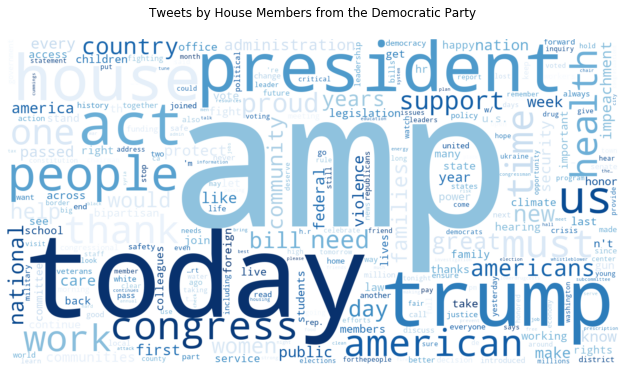

In [136]:
plt.figure(figsize=(12,6))
demo_wc = WordCloud(background_color="white", width=1500, height=800, 
                    max_words = 300, colormap = 'Blues')
demo_wc.generate_from_frequencies(demo_tfidf)

plt.imshow(demo_wc, interpolation="bilinear")
plt.title("Tweets by House Members from the Democratic Party", y=1.05)
plt.axis("off")
plt.show()

From the word clouds, we see that democrats love tweeting about present, Trump, people, today, congree and so on ;)

*Republican tweets word cloud*

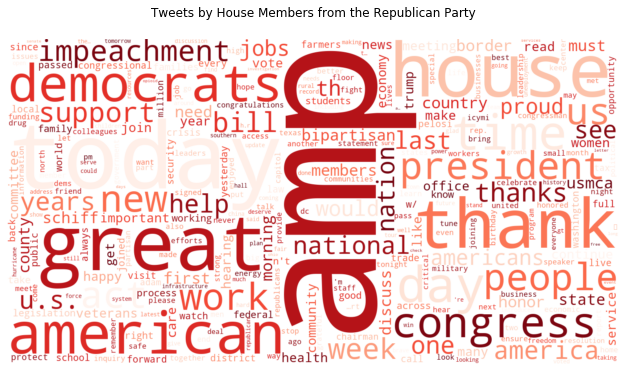

In [137]:
plt.figure(figsize=(12,6))
rep_wc = WordCloud(background_color="white", width=1500, height=800, 
                   max_words = 300, colormap = 'Reds')
rep_wc.generate_from_frequencies(rep_tfidf)

plt.imshow(rep_wc, interpolation="bilinear")
plt.title("Tweets by House Members from the Republican Party", y=1.05)
plt.axis("off")
plt.show()

The word great is often seen in republicans' tweets. Could it be because Trump uses it too many times? Other popular words include amp, american, thank, democrats and so on.

# Part 3: Sentiment analysis

## Exercise 5: Sentiment over the Twitter data

* **Download the LabMT wordlist. It's available as supplementary material from [Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752) (Data Set S1). Describe briefly how the list was generated.**

*The list was genereated in the following steps:*
1. The most frequently occurring 5000 words were drawn from each of the four text sources: Twitter, Google Books (English), music lyrics and the New York Times, resulting in a set of 10222 unique words that corresponds to the 10222 rows in the LabMT word list. The rank of each word in each source was recorded in the list as well.
2. Users on Amazon's Mechanical Turk were asked to rate the happiness of these words on a nine point integer scale, where 1 represents the least happy and 9 represents the most happy.
3. Compute the average happiness of each word and its standard deviation. Record the information in the list.

* **Based on the LabMT word list, write a function that calculates sentiment given a list of tokens (the tokens should be lower case, etc).**

In [138]:
# read data
S1 = pd.read_csv('Data_Set_S1.txt', sep="\t", header=0)
S1.head()

word  happiness_rank  happiness_average  happiness_standard_deviation  \
0   laughter               1               8.50                        0.9313   
1  happiness               2               8.44                        0.9723   
2       love               3               8.42                        1.1082   
3      happy               4               8.30                        0.9949   
4    laughed               5               8.26                        1.1572   

  twitter_rank google_rank nyt_rank lyrics_rank  
0         3600          --       --        1728  
1         1853        2458       --        1230  
2           25         317      328          23  
3           65        1372     1313         375  
4         3334        3542       --        2332

In [139]:
S1.shape

(10222, 8)

In [140]:
# create a dictionary mapping word to its happiness_average value
word_happiness = dict(zip(S1.word.tolist(), S1.happiness_average.tolist()))
word_happiness

{'laughter': 8.5,
 'happiness': 8.44,
 'love': 8.42,
 'happy': 8.3,
 'laughed': 8.26,
 'laugh': 8.22,
 'laughing': 8.2,
 'excellent': 8.18,
 'laughs': 8.18,
 'joy': 8.16,
 'successful': 8.16,
 'win': 8.12,
 'rainbow': 8.1,
 'smile': 8.1,
 'won': 8.1,
 'pleasure': 8.08,
 'smiled': 8.08,
 'rainbows': 8.06,
 'winning': 8.04,
 'celebration': 8.02,
 'enjoyed': 8.02,
 'healthy': 8.02,
 'music': 8.02,
 'celebrating': 8.0,
 'congratulations': 8.0,
 'weekend': 8.0,
 'celebrate': 7.98,
 'comedy': 7.98,
 'jokes': 7.98,
 'rich': 7.98,
 'victory': 7.98,
 'christmas': 7.96,
 'free': 7.96,
 'friendship': 7.96,
 'fun': 7.96,
 'holidays': 7.96,
 'loved': 7.96,
 'loves': 7.96,
 'loving': 7.96,
 'beach': 7.94,
 'hahaha': 7.94,
 'kissing': 7.94,
 'sunshine': 7.94,
 'beautiful': 7.92,
 'delicious': 7.92,
 'friends': 7.92,
 'funny': 7.92,
 'outstanding': 7.92,
 'paradise': 7.92,
 'sweetest': 7.92,
 'vacation': 7.92,
 'butterflies': 7.92,
 'freedom': 7.9,
 'flower': 7.88,
 'great': 7.88,
 'sunlight': 7.88,
 

*Calculate the sentimate of a list of tokens according to the formula presented in the paper below:*

<img src = "https://journals.plos.org/plosone/article/file?type=thumbnail&id=info:doi/10.1371/journal.pone.0026752.e006" style="float: left">

In [234]:
def sentiment(tokens):
    total=0
    count=0
    for t in tokens:
        # if the token t is found in the happiness list
        if t in word_happiness:
            total += word_happiness[t]
            count +=1
    # if no tokens are found in the happiness list
    if count == 0:
        return 0
    return total/count

* **Create two lists: one containing tweets by democratic members, and the other with the tweets of republican members. Calculate the sentiment of each tweet and plot the distribution of sentiment for each of the two lists. Are there significant differences between the two? Which party post more positive tweets?**

In [235]:
def get_tweets(path):
    tweets=[]
    text=open(path, encoding="utf-8")
    
    for line in text:
        # set all tweets to be lower case
        line=set_to_lower_case(line)
        if len(line) < 10:
            continue
        tweets.append(line)
    
    return tweets

In [236]:
def get_tweet_lists():
    
    republican=[]
    democratic=[]
    
    # iterate through all files in the folder
    for file in glob.glob("tweets_2019_full/*"):
        
        # extract the wikiname of the house member
        name = file[17:]
        
        # obtain the path of each file
        path = "tweets_2019_full/" + name
        
        # get tweets of each house member
        tweets = get_tweets(path)
        
        # obtain the member's party
        party = wikiName_party_dic[name]
        
        if party == 'Republican':
            republican.append(tweets)
        else:
            democratic.append(tweets)
    
    return (republican,democratic)

In [237]:
# get two lists of tweets for republican and democratic parties
# each is a list of lists, in which each inner list contains all tweets from a specific member of the house
# [[tweet1, tweet2, ...], [...], ...]
res=get_tweet_lists()
republican_list=res[0]
democratic_list=res[1]

In [238]:
# perform list comprehension so that now each list contains tweets from a party
# the result is a single list of the form: [tweet1, tweet2, ...]
republican_list=[j for x in republican_list for j in x]
democratic_list=[j for x in democratic_list for j in x]

In [239]:
# tokenize each tweet into a list of word tokens, and compute its average happiness score
# the rseult is a single list of the form: [tweet1_happiness, tweet2_happiness, ...]
republican_senti=[sentiment(tokenize(x)) for x in republican_list]
democratic_senti=[sentiment(tokenize(x)) for x in democratic_list]

In [240]:
# drop elements whose sentiment score is 0
# 0 sentiment score indicates that in that pariticular tweet, 
# there are no tokens that match to any of the words in the happiness word list
republican_senti = list(filter(lambda x: x!=0, republican_senti))
democratic_senti = list(filter(lambda x: x!=0, democratic_senti))

In [241]:
republican_senti

[5.509,
 5.613076923076923,
 5.42,
 6.24,
 5.55942857142857,
 5.390857142857143,
 5.946666666666666,
 5.27609756097561,
 5.807272727272728,
 5.37111111111111,
 5.0950000000000015,
 5.351304347826086,
 5.443750000000001,
 5.684186046511626,
 5.215454545454545,
 5.539047619047619,
 5.640000000000001,
 5.38388888888889,
 6.23,
 5.454545454545454,
 5.34,
 5.305000000000001,
 5.333181818181817,
 5.351999999999997,
 5.34344827586207,
 5.433333333333334,
 5.2070588235294135,
 4.776666666666666,
 5.556111111111111,
 5.043076923076923,
 5.522857142857142,
 4.953333333333333,
 5.312777777777779,
 5.656,
 5.602857142857142,
 5.035882352941178,
 5.632777777777777,
 5.585714285714286,
 5.630909090909091,
 5.414347826086956,
 5.456296296296297,
 5.5307692307692315,
 5.407441860465117,
 5.747000000000002,
 5.5520000000000005,
 5.5975,
 5.778181818181818,
 5.5430769230769235,
 5.154242424242423,
 5.566896551724136,
 5.771111111111112,
 4.991818181818182,
 5.594666666666666,
 5.54125,
 5.68620689655172

In [242]:
democratic_senti

[5.293170731707317,
 5.272142857142859,
 5.594482758620689,
 5.1140740740740736,
 5.343030303030303,
 5.400000000000001,
 5.6049999999999995,
 5.846666666666667,
 5.18,
 5.550000000000001,
 5.78625,
 5.041739130434783,
 5.036170212765958,
 5.313333333333333,
 5.057894736842106,
 5.066451612903226,
 5.675624999999999,
 4.954857142857142,
 5.009,
 5.62054054054054,
 5.495806451612902,
 5.449999999999999,
 5.4148387096774195,
 5.503333333333333,
 5.535,
 5.5912500000000005,
 4.846666666666667,
 5.496,
 5.38,
 5.1899999999999995,
 5.453548387096773,
 5.339999999999998,
 5.128085106382979,
 5.25016393442623,
 4.868,
 4.98,
 5.578709677419353,
 4.852500000000001,
 4.764285714285714,
 5.506956521739131,
 5.518974358974359,
 5.456666666666667,
 5.7,
 5.545454545454546,
 5.143529411764705,
 4.677142857142857,
 5.033333333333334,
 5.235999999999999,
 4.858750000000001,
 5.713333333333334,
 5.051578947368421,
 5.439047619047618,
 5.438,
 4.9975,
 5.079487179487179,
 5.134705882352941,
 5.32285714

*plot the distribution of sentiments*

In [243]:
# define bins to be used for the sentiment plot
bins=[i for i in np.arange(1,9.1,0.1)]

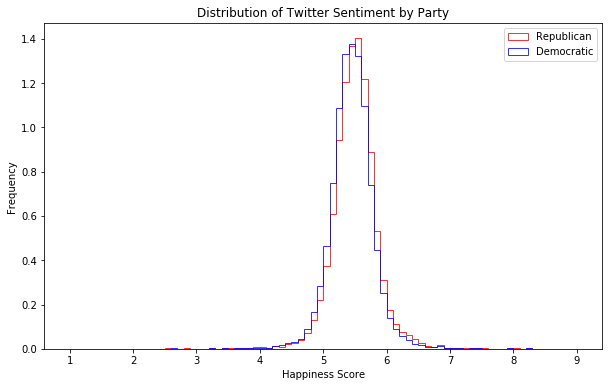

In [244]:
fig, ax = plt.subplots(figsize=(10,6))

ax.hist(republican_senti, histtype='step', 
         stacked=True, fill=False, bins = bins, alpha = 0.8, color="red", density = True) #normalized

ax.hist(democratic_senti,histtype='step', 
         stacked=True, fill=False, bins = bins, alpha = 0.8, color="blue", density = True) #normalized

ax.legend(('Republican','Democratic'))

ax.set_title("Distribution of Twitter Sentiment by Party")
ax.set_xlabel("Happiness Score")
ax.set_ylabel("Frequency")
plt.show()

*From the distribution plot, it can be seen that the happiness scores for both parties are similar in distribution*

* **Compute the average $m$ and standard deviation $\sigma$  of the Tweets sentiment (considering tweets by both republican and democrats).**

In [245]:
# concatenate the two lists together
all_senti = republican_senti + democratic_senti

In [246]:
# calculate the mean m and standard deviation σ of the concatenated list
senti_ave = statistics.mean(all_senti)
senti_std = statistics.stdev(all_senti)
print("The tweets have an average sentiment of {} and a standard deviation of {}".format(senti_ave, senti_std))

The tweets have an average sentiment of 5.471543169533458 and a standard deviation of 0.36329853511437143


* **Now only tweets with sentiment lower than $m-2\sigma$. We will refer to them as *negative* tweets.  Build a list containing *negative* tweets written by democrats, and one for republicans. Compute the TF-IDF on these two lists. Create a word-cloud for each of them. Are there differences between the negative content posted by republican and democrats?**

*tokenize negative tweets for both the Republican and the Democratic Party*

In [247]:
# calculat the value of m-2σ
neg_threshold = senti_ave - 2*senti_std
neg_threshold

4.744946099304715

In [248]:
# define a function that finds all negative tweets and join them into a single string
# input argument is a list of tweets [tweet1, tweet2, ...]

def find_neg_tweets(tweets):
    
    text = ""
    for tweet in tweets:
        senti_score = sentiment(tokenize(tweet))
        
        # exclude tweets that do not have any matching word in the happiness word list
        # and exclude tweets that exceed the negative tweets threshold
        # keep the rest of the tweets
        if senti_score != 0 and senti_score < neg_threshold:
            text += tweet
    
    return text

In [249]:
def process_neg_tweets(tweets):
    
    # find negative tweets from the list o f tweets
    text = find_neg_tweets(tweets)
    
    # replace new line character symbols in the text
    text = re.sub(r'\n', ' ', text)

    # remove urls in the text
    # urls have little use in gathering insight into house members' tweet patterns
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    
    # replace word character symbols in the text with a space
    text = re.sub(r'/w', ' ', text)
    
    # exclude twitter handles
    text = exclude_twitter_handles(text)
    
    # exclude numbers
    text = exclude_numbers(text)
    
    # set to lowercase
    text = set_to_lower_case(text)
       
    # add punctuations and stop words to one list
    to_be_removed = punctuations + stop_words + ["rt"]
    
    # tokenize the text
    word_tokens = tokenize(text)
        
    # remove punctuations and stop words
    word_tokens = [w for w in word_tokens if not w in to_be_removed]
    
    return word_tokens

In [250]:
# generate negative tokens for republicans and democrats
rep_neg_tokens = process_neg_tweets(republican_list)
demo_neg_tokens = process_neg_tweets(democratic_list)

In [251]:
rep_neg_tokens

['never',
 'forget',
 '🇺🇸',
 'forget',
 '🇺🇸',
 '️⃣️⃣️⃣',
 '️⃣…rt',
 'border',
 'crisis',
 'numbers',
 '❌',
 'fails',
 'address',
 'border',
 'crisis',
 '→',
 'grants',
 'amnesty',
 'violent',
 'criminals',
 'lowest',
 'unemployment',
 'years',
 'maga',
 '✅',
 'unemployment',
 '✅',
 'th',
 'consecutive',
 'month',
 'unemployment',
 'democrats',
 'continue',
 'deny',
 'crisis',
 'democrats',
 'continue',
 'deny',
 'crisis',
 'collusion',
 'obstruction',
 'republicans',
 'wo',
 "n't",
 'back',
 'demand',
 'transparency',
 'schiff',
 'caught',
 'lying',
 'wb',
 'contact',
 '⇒',
 'behind',
 'closed',
 'doors',
 '⇒',
 'without',
 'due',
 'process',
 'year',
 'low',
 'unemployment',
 'year',
 'low',
 'unemployment',
 'isis',
 'caliphate',
 'defeated',
 'lied',
 'question',
 'wait',
 'bomb',
 'threats',
 'become',
 'bomb',
 'blasts',
 'must',
 'zero',
 'tolerance',
 'anti-semitic',
 'hate',
 '-doesn',
 'undo',
 'damage',
 'schiff',
 'biased',
 'unfair',
 'sham',
 '▪️',
 'spread',
 'false',
 'a

In [252]:
demo_neg_tokens

['heartbreaking',
 'suicide',
 'children',
 'years',
 'old',
 'sad',
 'hoy',
 'honramos',
 'con',
 'los',
 'premioswola',
 'de',
 'derechoshumanos',
 'sept.',
 'national',
 'suicide',
 'prevention',
 'awareness',
 'month',
 'time',
 'address',
 'crisis',
 'veteran',
 'suicide',
 'gun',
 'violence',
 'kills',
 'americans',
 'day',
 'single',
 'virus',
 'bacteria',
 'killing',
 'americans',
 'day',
 'cdc',
 'would',
 'red',
 'alert',
 'never',
 'forget',
 'never',
 'forget',
 'may',
 'never',
 'forget',
 '✅invests',
 'innovation',
 'stock-buybacks',
 'fact',
 'abusive',
 'debt',
 'collection',
 'complaint',
 '✅',
 'senators',
 '✅',
 'ends',
 'ban',
 'medicare',
 'negotiating',
 'drug',
 'prices',
 '✅',
 'stops',
 'drug',
 'companies',
 'ripping',
 'americans',
 '✅address',
 'climate',
 'crisis',
 '-address',
 'climate',
 'crisis',
 '-gun',
 'violence',
 'survivors',
 '┻┳|',
 'impossible',
 '┻┳|',
 'impossible',
 'cohen',
 'prison',
 'manafort',
 'prison',
 'flynn',
 'guilty',
 'gates',
 

*Compute TF-IDF of the negative word token lists*

In [253]:
# get the list of tokens in common
neg_common_tokens = set(rep_neg_tokens).intersection(set(demo_neg_tokens))

In [254]:
rep_neg_tfidf = compute_tfidf(rep_neg_tokens, neg_common_tokens)
demo_neg_tfidf = compute_tfidf(demo_neg_tokens, neg_common_tokens)

In [255]:
rep_neg_tfidf

{'never': 0.003811338732729871,
 'forget': 0.003811338732729871,
 '🇺🇸': 0.0024199340360551865,
 '️⃣️⃣️⃣': 0.0008066446786850621,
 '️⃣…rt': 0.0008066446786850621,
 'border': 0.003811338732729871,
 'crisis': 0.0064316341114816575,
 'numbers': 0.0008066446786850621,
 '❌': 0.0007146260123868509,
 'fails': 0.00023820867079561695,
 'address': 0.0007146260123868509,
 '→': 0.0032265787147402482,
 'grants': 0.0008066446786850621,
 'amnesty': 0.0008066446786850621,
 'violent': 0.0007146260123868509,
 'criminals': 0.0012099670180275933,
 'lowest': 0.007384468794664126,
 'unemployment': 0.021200571700809908,
 'years': 0.004525964745116722,
 'maga': 0.0012099670180275933,
 '✅': 0.00786088613625536,
 'th': 0.0004764173415912339,
 'consecutive': 0.0008066446786850621,
 'month': 0.0014292520247737017,
 'democrats': 0.004287756074321105,
 'continue': 0.0007146260123868509,
 'deny': 0.0004764173415912339,
 'collusion': 0.006193425440686041,
 'obstruction': 0.00023820867079561695,
 'republicans': 0.00285

In [256]:
demo_neg_tfidf

{'heartbreaking': 0.0005691519635742744,
 'suicide': 0.0028457598178713715,
 'children': 0.0006424386949572928,
 'years': 0.001707455890722823,
 'old': 0.0032121934747864644,
 'sad': 0.0007588692847656991,
 'hoy': 0.0006424386949572928,
 'honramos': 0.0003212193474786464,
 'con': 0.001707455890722823,
 'los': 0.0038546321697437574,
 'premioswola': 0.0003212193474786464,
 'de': 0.0030354771390627964,
 'derechoshumanos': 0.0003212193474786464,
 'sept.': 0.0003212193474786464,
 'national': 0.0007588692847656991,
 'prevention': 0.0028457598178713715,
 'awareness': 0.0003212193474786464,
 'month': 0.0011383039271485487,
 'time': 0.0022766078542970974,
 'address': 0.0020868905331056726,
 'crisis': 0.004173781066211345,
 'veteran': 0.00037943464238284955,
 'gun': 0.014797951052931132,
 'violence': 0.015556820337696831,
 'kills': 0.0009636580424359394,
 'americans': 0.0022766078542970974,
 'day': 0.0011383039271485487,
 'single': 0.002248535432350525,
 'virus': 0.0003212193474786464,
 'bacteri

*plot word clouds for the negative tweets*

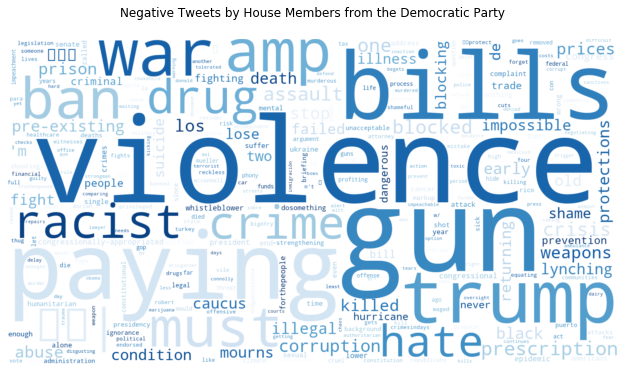

In [257]:
plt.figure(figsize=(12,6))
demo_neg_wc = WordCloud(background_color="white", width=1500, height=800, max_words = 300, colormap = 'Blues')
demo_neg_wc.generate_from_frequencies(demo_neg_tfidf)

plt.imshow(demo_neg_wc, interpolation="bilinear")
plt.axis("off")
plt.title("Negative Tweets by House Members from the Democratic Party", y=1.05)
plt.show()

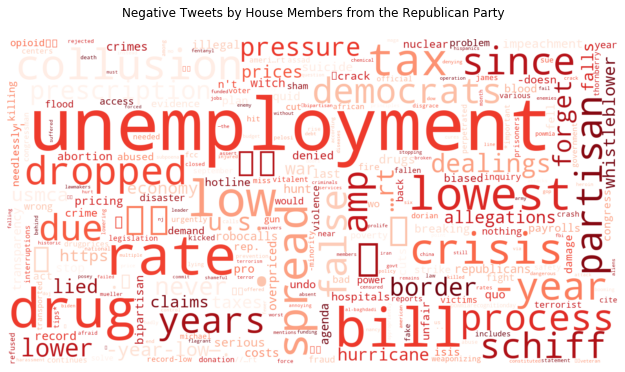

In [258]:
plt.figure(figsize=(12,6))
rep_neg_wc = WordCloud(background_color="white", width=1500, height=800, max_words = 300, colormap = 'Reds')
rep_neg_wc.generate_from_frequencies(rep_neg_tfidf)

plt.imshow(rep_neg_wc, interpolation="bilinear")
plt.axis("off")
plt.title("Negative Tweets by House Members from the Republican Party", y=1.05)
plt.show()

It is not surprising that Trump appears in Democrats' negative tweets. From the word clouds, it can also be seen that democrats tweet more negatively about gun policy, violence, drugs and war, whereas republicans are more concerned about unemployment rates, tax and abortion!

* **Repeat the point above, but considering _positive_ tweets (e.g. with sentiment larger than $m+2\sigma$). Comment on your results.**

*tokenize positive tweets for both the Republican and the Democratic Party*

In [259]:
# calculat the value of m+2σ
pos_threshold = senti_ave + 2*senti_std
pos_threshold

6.198140239762201

In [260]:
# define a function that finds all positive tweets and join them into a single string
# input argument is a list of tweets [tweet1, tweet2, ...]

def find_pos_tweets(tweets):
    
    text = ""
    for tweet in tweets:
        senti_score = sentiment(tokenize(tweet))
        
        # keep only tweets that exceed the positive threshold
        if senti_score > pos_threshold:
            text += tweet
    
    return text

In [261]:
def process_pos_tweets(tweets):
    
    # find negative tweets from the list o f tweets
    text = find_pos_tweets(tweets)
    
    # replace new line character symbols in the text
    text = re.sub(r'\n', ' ', text)

    # remove urls in the text
    # urls have little use in gathering insight into house members' tweet patterns
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    
    # replace word character symbols in the text with a space
    text = re.sub(r'/w', ' ', text)
    
    # exclude twitter handles
    text = exclude_twitter_handles(text)
    
    # exclude numbers
    text = exclude_numbers(text)
    
    # set to lowercase
    text = set_to_lower_case(text)
       
    # add punctuations and stop words to one list
    to_be_removed = punctuations + stop_words + ["rt"]
    
    # tokenize the text
    word_tokens = tokenize(text)
        
    # remove punctuations and stop words
    word_tokens = [w for w in word_tokens if not w in to_be_removed]
    
    return word_tokens

In [262]:
# generate positive tokens for republicans and democrats
rep_pos_tokens = process_pos_tweets(republican_list)
demo_pos_tokens = process_pos_tweets(democratic_list)

In [263]:
rep_pos_tokens

['new',
 'museum',
 'opens',
 'middleport',
 'happy',
 'th',
 'anniversary',
 'national',
 'pow/mia',
 'recognition',
 'day',
 'great',
 'visit',
 'marietta',
 'plant',
 'employs',
 'people',
 'locally',
 'great',
 'news',
 'wishing',
 'everyone',
 'safe',
 'happy',
 'independenceday',
 'happy',
 'th',
 'birthday',
 'lucasville',
 'big',
 'celebration',
 'weekend',
 'celebrating',
 'bicentennial',
 'resources',
 'veteransaffairs',
 'wehelp',
 'lalege',
 'lagov',
 'acadiana',
 'parishes',
 'begin',
 'ordering',
 'voluntary',
 'evacuations',
 'happy',
 'independence',
 'day',
 'may',
 'god',
 'continue',
 'bless',
 'america',
 'years',
 'statehood',
 'happy',
 'birthday',
 'louisiana',
 'wishing',
 'blessed',
 'easter',
 'sunday',
 'let',
 'us',
 'celebrate',
 'resurrection',
 'loving',
 'forgiving',
 'savior',
 'happy',
 'mardi',
 'gras',
 'deserve',
 'transparency',
 'love',
 '🙌🙌🙌🙌🙌🙌🙌',
 'rising',
 'wages',
 'better',
 'trade',
 'deals',
 'energy',
 'dominance',
 'rising',
 'wages',
 '

In [264]:
demo_pos_tokens

['happy',
 'b-day',
 'son',
 'chris',
 'big',
 'today',
 'sons',
 'safe',
 'julio',
 'cesar',
 '🙏🏼',
 'brothers',
 'uncles',
 'nephew',
 'dad',
 'grandpa',
 'teamtorres',
 'hispanicheritagemonth',
 'good',
 'news',
 'happy',
 'constitution',
 'day',
 'happy',
 'birthday',
 'america',
 'happy',
 'independenceday',
 'wishing',
 'families',
 'safe',
 'happy',
 'thofjuly',
 'living',
 'kidney',
 'donors',
 'save',
 'lives',
 'make',
 'america',
 'fair',
 'happy',
 'birthday',
 'billy',
 'joel',
 'happy',
 'earth',
 'day',
 'good',
 'morning',
 'thanks',
 '만세',
 'great',
 'celebration',
 'honor',
 'get',
 'well',
 'soon',
 'wishing',
 'speedy',
 'recovery',
 'watch',
 'online',
 'wealthgap',
 'inequity',
 'wishing',
 'everyone',
 'fun',
 'safe',
 'halloween',
 'family',
 'friends',
 'tonight',
 'happyhalloween',
 '🗓',
 'tomorrow',
 'saturday',
 'october',
 'th',
 'please',
 'stay',
 'safe',
 'power',
 'outage',
 'safety',
 'tips',
 '-abandoned',
 'allies',
 'thank',
 'president',
 'leshin',

*Compute TF-IDF of the positive word token lists*

In [265]:
# get the list of tokens in common
pos_common_tokens = set(rep_pos_tokens).intersection(set(demo_pos_tokens))

In [266]:
rep_pos_tfidf = compute_tfidf(rep_pos_tokens, pos_common_tokens)
demo_pos_tfidf = compute_tfidf(demo_pos_tokens, pos_common_tokens)

In [267]:
rep_pos_tfidf

{'new': 0.011317073170731707,
 'museum': 0.0003303701815726723,
 'opens': 0.0003303701815726723,
 'middleport': 0.0003303701815726723,
 'happy': 0.05112195121951219,
 'th': 0.00448780487804878,
 'anniversary': 0.0013658536585365853,
 'national': 0.0037073170731707315,
 'pow/mia': 0.0003303701815726723,
 'recognition': 0.0001951219512195122,
 'day': 0.023414634146341463,
 'great': 0.020097560975609757,
 'visit': 0.001951219512195122,
 'marietta': 0.0003303701815726723,
 'plant': 0.0003303701815726723,
 'employs': 0.0003303701815726723,
 'people': 0.0021463414634146343,
 'locally': 0.0003303701815726723,
 'news': 0.00448780487804878,
 'wishing': 0.009951219512195122,
 'everyone': 0.002926829268292683,
 'safe': 0.00448780487804878,
 'independenceday': 0.0015609756097560976,
 'birthday': 0.019121951219512195,
 'lucasville': 0.0003303701815726723,
 'big': 0.0005853658536585366,
 'celebration': 0.0003902439024390244,
 'weekend': 0.0023414634146341463,
 'celebrating': 0.007804878048780488,
 '

In [268]:
demo_pos_tfidf

{'happy': 0.04422476586888657,
 'b-day': 0.00044046492730487655,
 'son': 0.0007804370447450572,
 'chris': 0.00044046492730487655,
 'big': 0.0007804370447450572,
 'today': 0.005723204994797087,
 'sons': 0.0008809298546097531,
 'safe': 0.005983350676378772,
 'julio': 0.00044046492730487655,
 'cesar': 0.00044046492730487655,
 '🙏🏼': 0.00044046492730487655,
 'brothers': 0.0008809298546097531,
 'uncles': 0.00044046492730487655,
 'nephew': 0.00044046492730487655,
 'dad': 0.0005202913631633715,
 'grandpa': 0.00044046492730487655,
 'teamtorres': 0.00044046492730487655,
 'hispanicheritagemonth': 0.002642789563829259,
 'good': 0.005983350676378772,
 'news': 0.0015608740894901144,
 'constitution': 0.00026014568158168577,
 'day': 0.007284079084287201,
 'birthday': 0.010145681581685745,
 'america': 0.0028616024973985433,
 'independenceday': 0.0015608740894901144,
 'wishing': 0.012486992715920915,
 'families': 0.003121748178980229,
 'thofjuly': 0.0017618597092195062,
 'living': 0.00044046492730487655

*plot word clouds for the positive tweets*

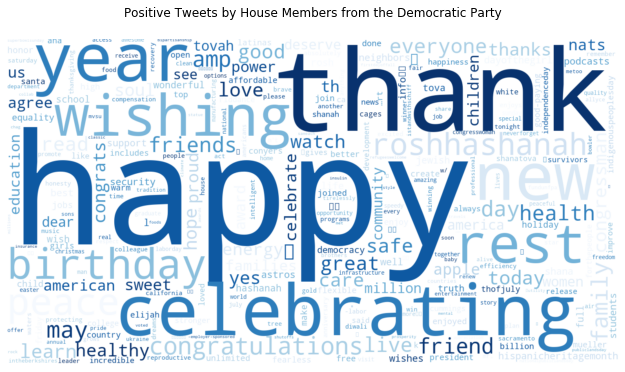

In [269]:
plt.figure(figsize=(12,6))
demo_pos_wc = WordCloud(background_color="white", width=1500, height=800, max_words = 300, colormap = 'Blues')
demo_pos_wc.generate_from_frequencies(demo_pos_tfidf)

plt.imshow(demo_pos_wc, interpolation="bilinear")
plt.axis("off")
plt.title("Positive Tweets by House Members from the Democratic Party", y=1.05)
plt.show()

Positive words tweeted by Democrats include happy, thank, wishing, celebrating and so on.

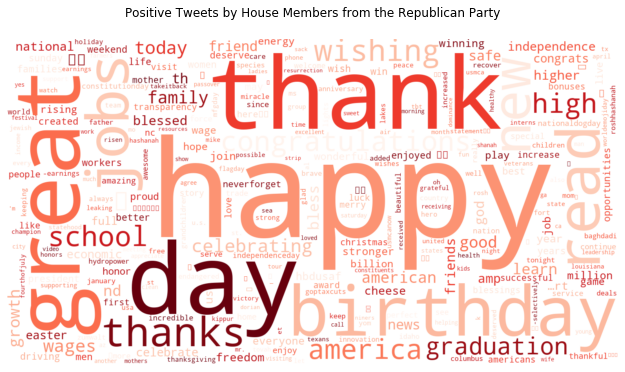

In [270]:
plt.figure(figsize=(12,6))
rep_pos_wc = WordCloud(background_color="white", width=1500, height=800, max_words = 300, colormap = 'Reds')
rep_pos_wc.generate_from_frequencies(rep_pos_tfidf)

plt.imshow(rep_pos_wc, interpolation="bilinear")
plt.axis("off")
plt.title("Positive Tweets by House Members from the Republican Party", y=1.05)
plt.show()

Positive words tweeted by Repulicans include happy, birthday, great, thank and so on.